# Data Exploration

### Reading the u.data file

In [1]:
import pandas as pd

PATH = "../data/raw/ml-100k/"

ratings_columns = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    PATH + "u.data", sep="\t", names=ratings_columns, encoding="latin-1"
)

print(ratings.isnull().values.any())
# No NaNs, good!
ratings.head()

False


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Checking the amount of ratings for each movie

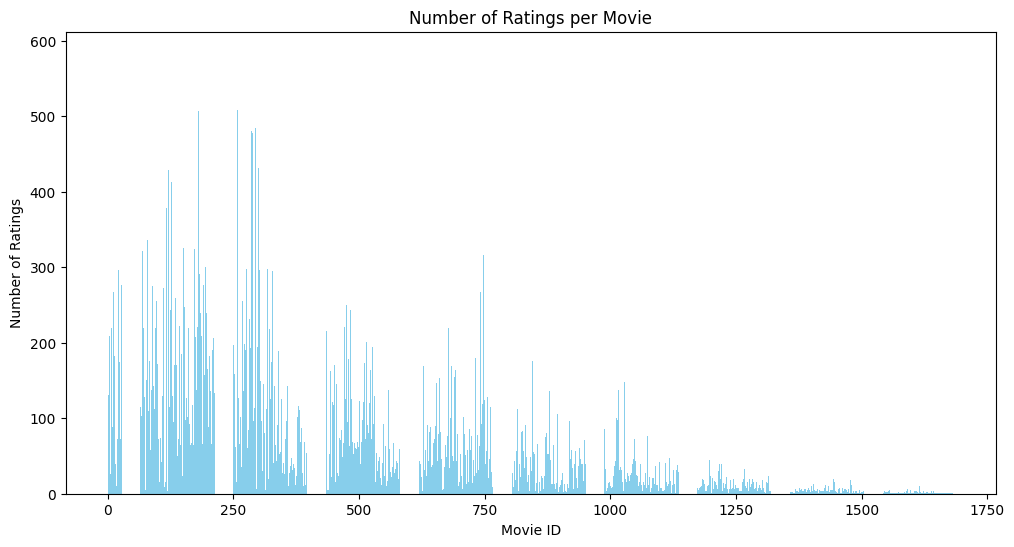

In [2]:
import matplotlib.pyplot as plt

ratings_count = ratings.groupby('movie_id').size()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(ratings_count.index, ratings_count.values, color='skyblue')
plt.title('Number of Ratings per Movie')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()

I won't drop anything, because the films that don't have enough ratings might mean that the film has just been released. Also, if I remove the non-popular movies, that would mean that my system would recommend only the popular films, which you might have watched already.

### Creating test and train datasets based on the u1 split

In [3]:
ratings_train = pd.read_csv(
    PATH + "u1.base", sep="\t", names=ratings_columns, encoding="latin-1"
)

ratings_test = pd.read_csv(
    PATH + "u1.test", sep="\t", names=ratings_columns, encoding="latin-1"
)
ratings_train.drop(['timestamp'], axis=1, inplace=True)
ratings_test.drop(['timestamp'], axis=1, inplace=True)

ratings_train.to_parquet('../data/interim/ratings_train.parquet')
ratings_test.to_parquet('../data/interim/ratings_test.parquet')

### Checking the movie data for NaNs

In [4]:
movie_columns = [
    "movie_id",
    "title",
    "release_date",
    "video_release_date",
    "IMDb_URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
movies = pd.read_csv(PATH + "u.item", sep="|", names=movie_columns, encoding="latin-1")

print(movies['video_release_date'].isnull().values.all())
# video_release_date has only NaNs, so dropping!
# Also dropping imdb_url and title because they don't serve any purpose in recommendations.
# Also will drop the release date because I don't know what to do with it:)
movies.drop(['video_release_date', 'IMDb_URL', 'title', 'release_date'], axis=1, inplace=True)
print(movies.isnull().values.all())
# No NaNs left, cool!
movies.head()

True
False


,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [5]:
# Saving for future use
movies.to_parquet('../data/interim/movies.parquet')

### One-hot encoding occupation and genders for the users' dataset

In [6]:
user_columns = ["user_id", "age", "gender", "occupation", "zip_code"]
users = pd.read_csv(PATH + "u.user", sep="|", names=user_columns, encoding="latin-1")

# One-hot encoding columns
# Dropping zipcode to reduce complexity since I don't have resources to give recommendation based on the state you are in
users.drop(['zip_code'], axis=1, inplace=True)
users = pd.get_dummies(users, columns=['gender', 'occupation'])
users.head()

,user_id,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,24,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,2,53,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,3,23,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,4,24,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,33,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


### Checking the age distribution to see what I can do with it

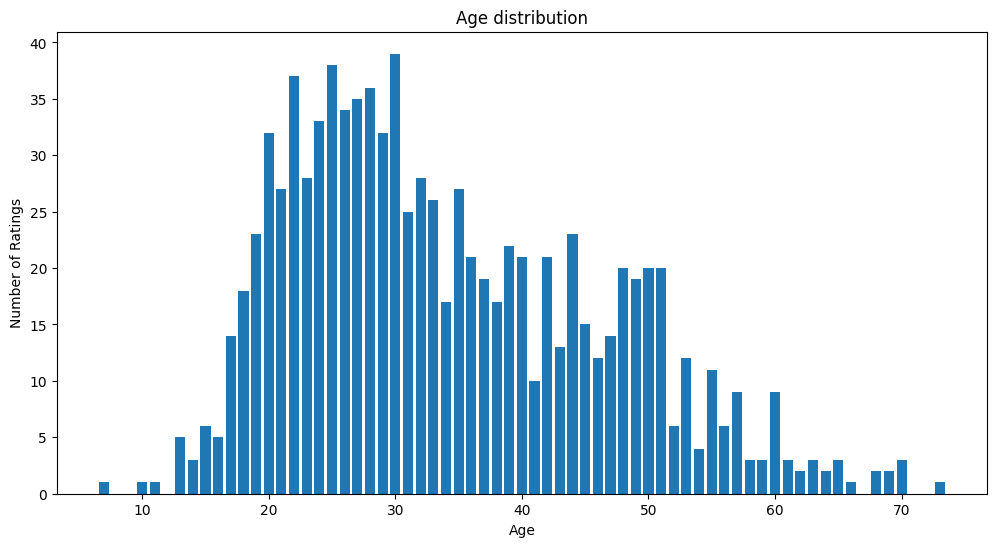

In [7]:
import matplotlib.pyplot as plt

users_age = users.groupby('age').size()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(users_age.index, users_age.values)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of Ratings')
plt.show()

I decided to one-hot encode age based on the age group <br>
young = <25<br>
adults = 25-55<br>
seniors = 55+<br>


### Replacing the age column with the approach I suggested

In [8]:
users["young"] = users["age"].apply(lambda x: 1 if x < 25 else 0)
users["adult"] = users["age"].apply(lambda x: 1 if 25 <= x <= 55 else 0)
users["senior"] = users["age"].apply(lambda x: 1 if x > 55 else 0)
users.drop(["age"], axis=1, inplace=True)
users.head()

Index(['user_id', 'gender_F', 'gender_M', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer',
       'young', 'adult', 'senior'],
      dtype='object')

### Checking the age distribution

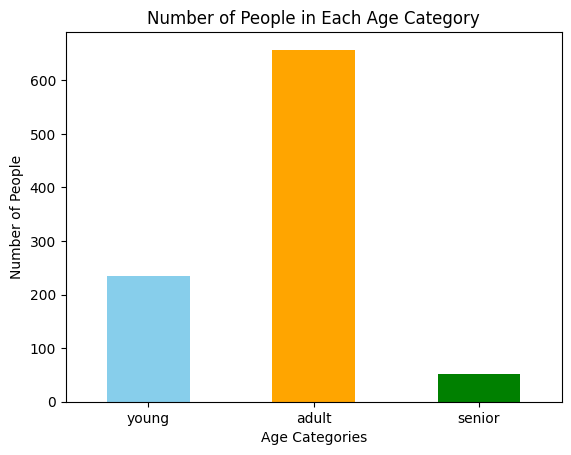

In [9]:
import matplotlib.pyplot as plt

age_categories_count = users[["young", "adult", "senior"]].sum()

# Plotting
age_categories_count.plot(kind="bar", color=["skyblue", "orange", "green"])
plt.title("Number of People in Each Age Category")
plt.xlabel("Age Categories")
plt.ylabel("Number of People")
plt.xticks(rotation=0)
plt.show()

In [11]:
# Saving for future use in the models
users.to_parquet("../data/interim/users.parquet")